# REMEMBER TO TRUST THE NOTEBOOK TO SEE GRAPHS!

## Prefix: Assignment structure

The following assignment will be structured as follows:

## Part \<Part number\>: \<Title\>

Under each part, a set of tasks are then structured as:
### (Optional) \<Exercise\>
### \<Headline of a task\>
(optional) \<Some text describing the context of the task\>

*The specific question in cursive*

#### Solution
\<The solution in terms of code and markdown cells\>

# Assignment 2

In [1]:
import pandas as pd

# Ignore deprecation warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]

df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv",
                 usecols=column_list)

## Part 1: Predicting criminal recidivism

### Preprocessing

*Preprocess the data by only keeping records that have between $-30$ and $30$ days between the arrest and screening, then drop the `days_b_screening_arrest` column for the upcoming analysis.*

#### Solution

In [3]:
# Create a mask for filtering the dataframe
mask = (-30 <= df.days_b_screening_arrest) & (df.days_b_screening_arrest <= 30)

# Apply the mask
df = df[mask]

# Drop column
df = df.drop(['days_b_screening_arrest'], axis=1)

In [4]:
# Define features and target after dropping `days_b_screening_arrest`
features = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]

target = ["two_year_recid"]

### Encoding
Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the `OneHotEncoder` and the `LabelEncoder`:

*Which encoder did you choose? Describe what it does and why you chose it.*

#### Solution

In [5]:
from sklearn.preprocessing import LabelEncoder

# Categorical features are sex and race
categorical_features = ['sex', 'race']


def encode_data(df):
    """
    Function to encode the dataset for the model
    :param df: Dataframe with data
    :return: Encoded dataframe and the label encoder objects
    """

    # Copy the dataframe so it doesn't change the original dataframe
    df_model = df.copy()
    encoders = dict()

    # Iterate over categorical columns and encode them
    for col in categorical_features:
        encoder = LabelEncoder()
        df_model[col] = encoder.fit_transform(df_model[col])
        encoders[col] = encoder

    return df_model, encoders


# Build the data
df_model, encoders = encode_data(df)

In [6]:
# Display encoding mappings
print('Sex encodings:', dict(zip(df.sex.unique(), encoders['sex'].transform(df.sex.unique()))))
print('Race encodings:', dict(zip(df.race.unique(), encoders['race'].transform(df.race.unique()))))

Sex encodings: {'Male': 1, 'Female': 0}
Race encodings: {'Other': 5, 'African-American': 0, 'Caucasian': 2, 'Hispanic': 3, 'Asian': 1, 'Native American': 4}


### Split the data

*Split the data in Train/Test sets by using a 70/30 split and `random_state=42`.*

#### Solution


In [7]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model[target], test_size=0.3,
                                                    random_state=42)

### Fit a model
Fit a model to your Train set. Choose between a `DecisionTreeClassifier` or a `RandomForestClassifier`.

*Describe how the model you chose works and why you chose it.*

#### Solution


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Create model object
model = RandomForestClassifier()

# Fit
model = model.fit(X=X_train, y=y_train)

**Answer:**
* A `RandomForestClassifier` fits a number of decision tree classifiers on sub-samples of the dataset and uses the average across trees (hence the name 'Forest') to improve the accuracy and control over-fitting. This technique is generally known as *Ensemble modelling*
* We chose this classifier as it is a common extension on top of the `DecisionTreeClassifier` which accounts for over-fitting and generally has better accuracy. However, training times increase and interpretability is reduced. For our case, training time is no issue and we can still apply some methods to interpret the random forest as we will see later [\[1\]](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/)

### Evaluation of model performance

Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall.

*What are your thoughts on these metrics? Is accuracy a good measure?*

#### Solution


In [9]:
from sklearn.metrics import classification_report

# Predict on test set
y_hat = model.predict(X_test)

# Show classification report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1020
           1       0.61      0.58      0.59       832

    accuracy                           0.64      1852
   macro avg       0.64      0.64      0.64      1852
weighted avg       0.64      0.64      0.64      1852



**Answer:**
* We see that the precision, recall and f1-score is much better for the negative prediction (0) than the positive prediction (1). Especially the recall has a difference of `0.13` which shows that the model is much better at capturing people who don't recommit crimes than people who do recommit crimes.
* The accuracy is `0.64` and fails to capture the bias of the model in terms of predicting more negative cases than positive ones.

### Hyperparameters

Perform a `RandomizedSearchCV` and recompute the performance metric above with the hyperparameters found.

*Are your results tied to the specific hyperparameter set you used?*

*What do you observe?*

#### Solution


In [10]:
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=150, num=30)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2, 4, 6]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# Create model object
model = RandomForestClassifier()

# Setup hyperparam search
clf = RandomizedSearchCV(model, param_grid, random_state=42)

# Fit
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 14, 19, 24, 29, 34,
                                                         38, 43, 48, 53, 58, 63,
                                                         67, 72, 77, 82, 87, 92,
                                                         96, 101, 106, 111, 116,
                                                         121, 125, 130, 135,
                                                         140, 145, 150]},
                   random_state=42)

In [94]:
# Show new classification report
y_hat = clf.predict(X_test)

print('Best parameters:', clf.best_params_)

print('New classification report with optimized hyperparameters')
print(classification_report(y_test, y_hat))

Best parameters: {'n_estimators': 48, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': False}
New classification report with optimized hyperparameters
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1020
           1       0.65      0.61      0.63       832

    accuracy                           0.67      1852
   macro avg       0.67      0.67      0.67      1852
weighted avg       0.67      0.67      0.67      1852



**Answer:**
* First of all, we see a generally improved accuracy and weighted average over precision and recall. This indicates that it is indeed influenced by the choice of hyperparameters.
* We observe that the all metrics have increased in the range `0.03 - 0.04`. However, the difference in recall is still apparent.

### Visualizing the tree
Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it.

*What do you observe?*
#### Solution


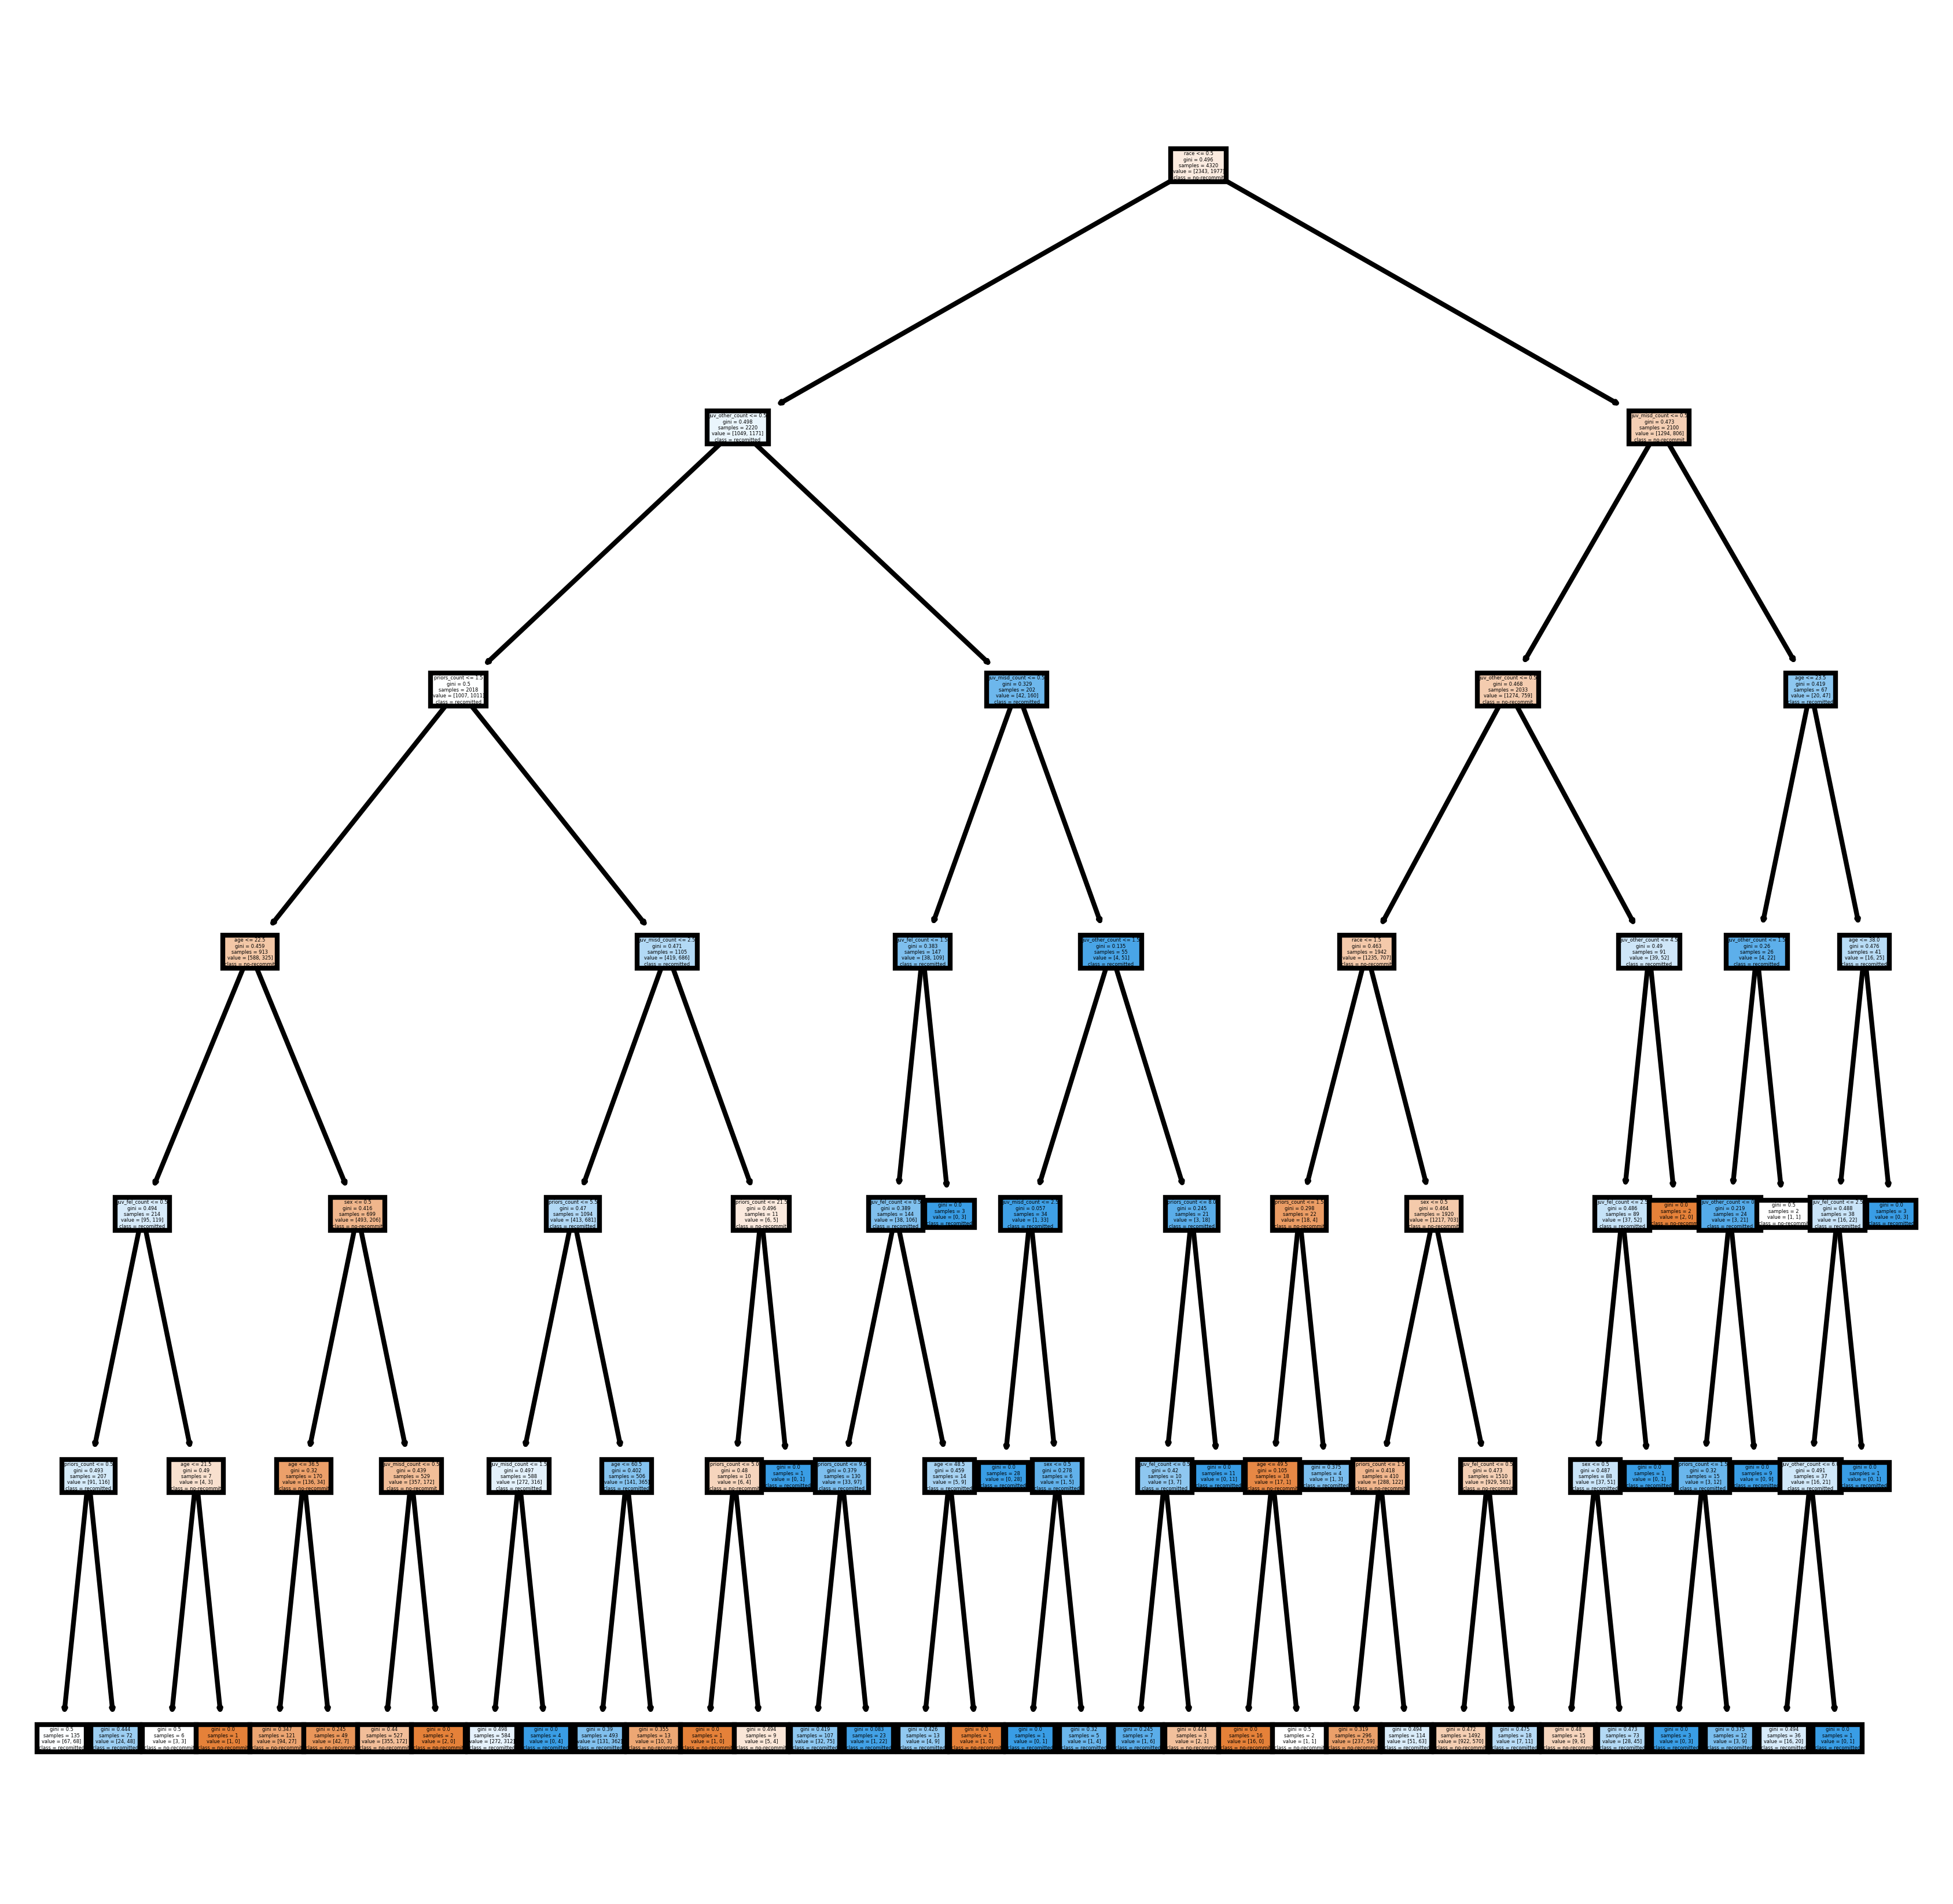

YOU CAN ZOOM USING `CTRL + MOUSE SCROLL` ON THE PICTURE


In [28]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the best model
best_model = clf.best_estimator_

# Plot tree
plt.figure(figsize=(7, 7), dpi=600)
plot_tree(best_model.estimators_[0],
          feature_names=features,
          class_names=['no-recommit', 'recomitted'],
          filled=True)

# Show tree
plt.show()

print('YOU CAN ZOOM USING `CTRL + MOUSE SCROLL` ON THE PICTURE')

**Answer:**
* On the root node we observe that the split is on `age <= 34.5` which shows that age has the highest impact on the model's decisions. Thereafter, we notice that the two children to the root node split on `sex <= 0.5` (left) and `priors_count <= 4.5` (right). Which indicates that these features also play a significant part when predicting if the person will recommit crimes.

Before going on. Assign the predictions on the test set of your best model to the `y_hat` variable, and their related probabilities to the `y_prob` variable. Remember to use: `y_prob = model.predict_proba(X_test)`

**N.B.** Set a specific `random_state` in your model too. Otherwise if we rerun your results we might not be able to reproduce them!

In [95]:
y_hat = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

## Part 2: Fairness and bias in Machine Learning

### Exercise 2.1: Data bias

### Common types of data bias

*What are the most common types of data bias?*

#### Solution

**Answer:**

| **Bias Type**                        | **Short Description**                                                                                                                                                                                                        |
|--------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Response or Activity Bias            | Occurs mostly in content generated by humans (reviews, posts, etc).  Leads to bias due to a limited population, low variety of data sources and low variety across demographic and geographic groups                         |
| Selection bias due to feedback loops | Occurs when a model influences it's own data for future training. Leads to bias in ML models such as recommender systems when users focus on a small subset of items.                                                        |
| Bias due to system drift             | Occurs when a system's data changes over time. Leads to bias when the definition of the target changes or users interact differently compared to when the model was trained.                                                 |
| Omitted variable bias                | Occurs when critical variables are missing from data. This could happen when there is a lack of access or privacy concerns.  It's critical because the variable is correlated with the target or other features of the model |
| Societal bias                        | Occurs when the content is produced by humans (social media or curated news articles). It happens when data itself contains bias or stereotypes. This leads to models that will bias on race, gender or other categories.    |

### Sources of data bias

*What are the potential bias sources/types in our case-study (i.e. recidivism)?*

#### Solution

**Answer:**
* The data comes from the **COMPAS** (Correctional Offender Management Profiling for Alternative Sanctions) algorithm which has been shown to bias towards non-caucasian people [\[2\]](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). This is a sign of **Societal bias** as the model (or algorithm) in this case is heavily biased on ethnicity / race.

### Exercise 2.2: Equal Odds

### Threshold function

*Define the thresholds as `ths = np.linspace(1e-5,1-1e-5, 10)` and create a function that given a threshold `th` and `y_prob` returns `y_hat` as:*

$$\begin{cases}\hat{y}=1, \mbox{ if } y_{prob} > th \\ \hat{y}=0, \mbox{ otherwhise}\end{cases}    \mbox(1)$$

#### Solution

In [160]:
ths = np.linspace(1e-5,1-1e-5, 10)

In [98]:
from sklearn.metrics import confusion_matrix


def get_y_hat(y_prob, th):
    """
    Returns predictions from probabilities and a threshold

    :param y_prob: Model probabilities
    :param th: a threshold between 0 and 1
    :return: Transformed probabilities
    """
    return [1 if x > th else 0 for x in y_prob[:, 1]]

def get_tpr_fpr(y_hat, y_true):
    """
    :param y_hat: Target scores
    :param y_true: True targets
    :return: true positive rate and false positive rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

In [99]:
# Testing the function with threshold of 1, should give tpr=0 and fpr=0
y_hat_ = get_y_hat(best_model.predict_proba(X_test), 1)
tpr, fpr = get_tpr_fpr(y_hat_, y_test)
assert tpr + fpr == 0
print(tpr, fpr)

# Testing the function with threshold of 0, should give tpr=1 and fpr=1
y_hat_ = get_y_hat(best_model.predict_proba(X_test), 0)
tpr, fpr = get_tpr_fpr(y_hat_, y_test)
assert tpr + fpr == 2
print(tpr, fpr)

0.0 0.0
1.0 1.0


### Finding the two thresholds

To find the two thresholds that correct for the bias for African-Americans and Caucasians, you can either compute the distance of the ROC curve points or visually find the thresholds (as described in Week 7 Ex. 3.3).

*Describe the method you have used to find the thresholds (i.e. Visual or Computational) and how you used it to identify the thresholds. What thresholds did you find?*

#### Solution

In [161]:
#This function takes as an input y, y_probs, thr
#and returns the points to plot the ROC curve and their threshold
def roc_curve(y, y_probs, ths):
    #initialize roc as an empty np.array
    roc = np.array([])
    #loop over thresholds
    for th in ths:
        #convert y_prob in y_hat
        y_hat = get_y_hat(y_probs, th)
        #compute TPR and FPR
        TPR, FPR = get_tpr_fpr(y_hat, y)
        #add threshold and point to roc array
        roc = np.append(roc, [th, FPR, TPR])

    #return roc
    return roc.reshape(-1, 3)

In [162]:
# Display encoding mappings
print('Race encodings:', dict(zip(df.race.unique(), encoders['race'].transform(df.race.unique()))))

Race encodings: {'Other': 5, 'African-American': 0, 'Caucasian': 2, 'Hispanic': 3, 'Asian': 1, 'Native American': 4}


In [163]:
# Define data for caucasian and african-american races. Refer to the 'Encoding' section where the mappings are printed

# Caucasian
ca_idx = X_test.query('race == 2').index

X_test_ca = X_test.filter(items = ca_idx, axis=0)
y_test_ca = y_test.filter(items = ca_idx, axis=0)

# African-American
aa_idx = X_test.query('race == 0').index

X_test_aa = X_test.filter(items = aa_idx, axis=0)
y_test_aa = y_test.filter(items = aa_idx, axis=0)

In [164]:
roc_ca = roc_curve(y_test_ca, clf.predict_proba(X_test_ca), ths)
roc_aa = roc_curve(y_test_aa, clf.predict_proba(X_test_aa), ths)

In [165]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

source = ColumnDataSource(pd.DataFrame(np.hstack([roc_aa, roc_ca[:,1:]]), columns=['th', 'FPR_AA', 'TPR_AA', 'FPR_CA', 'TPR_CA']))
p = figure(title='ROC Curves for Caucasian and African-American groups',
           x_axis_label='FPR',
           y_axis_label='TPR',
           tooltips=[
               ('Threshold', '@th'),
           ],
           x_range=[0, 1],
           y_range=[0, 1])

p.line('FPR_AA', 'TPR_AA', color='red', line_width=4, legend_label='African-American', source=source)
p.line('FPR_CA', 'TPR_CA', color='blue', line_width=4, legend_label='Caucasian', source=source)
p.circle('FPR_AA', 'TPR_AA', color='red', size=10, legend_label='African-American', source=source)
p.circle('FPR_CA', 'TPR_CA', color='blue', size=10, legend_label='Caucasian', source=source)

p.legend.location = 'top_left'

output_notebook()
show(p)

Loading BokehJS ...

**Answer:**
We used the *Visualization* method for finding the thresholds. The procedure is as follows

1. We plot the roc curves on the same graph as seen above.
2. By visual inspection, we find the points that are closest together. This is found at the points around FPR=0.1 and TPR=0.4
3. Using the hover-tooltip, the thresholds are read from the graph:
    * Caucasian: `th = 0.556`
    * African-American: `th = 0.667`

### Debiasing the model

*Debias the model output by re-computing $\hat{y}$ with the thresholds you found.*

* **Hint 1** This means that you have to take `y_prob` of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
* **Hint 2** You shouldn't rerun your model!

#### Solution

In [111]:
# Set thresholds
th_ca = 0.556
th_aa = 0.667

In [112]:
# Predict on test set for each group and adjust based on the found threshold
y_hat_ca_adj = get_y_hat(best_model.predict_proba(X_test_ca), th_ca)
y_hat_aa_adj = get_y_hat(best_model.predict_proba(X_test_aa), th_aa)

### Confusion Matrices

Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method.

*What do you observe? What do you think the problem with this debiasing method is?*

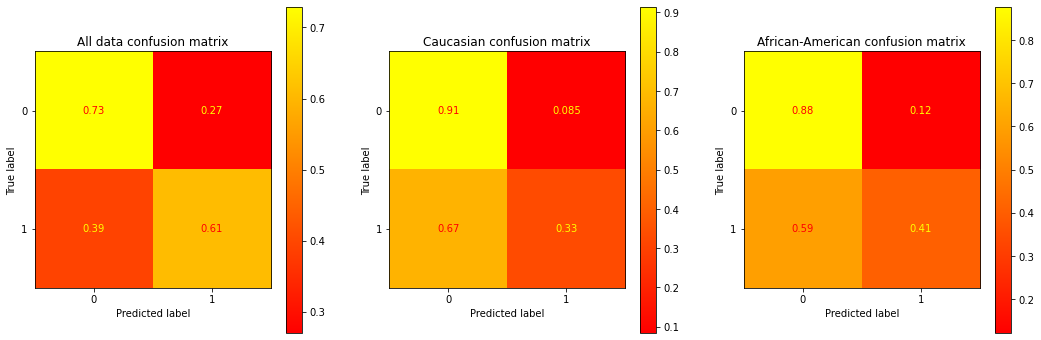

In [124]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 3, figsize=(18,6))

# Plot confusion matrices in the same subplot
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_hat, cmap='autumn', normalize='true', ax=axs[0])
axs[0].set_title('All data confusion matrix')

ConfusionMatrixDisplay.from_predictions(y_true=y_test_ca, y_pred=y_hat_ca_adj, cmap='autumn', normalize='true', ax=axs[1])
axs[1].set_title('Caucasian confusion matrix')

ConfusionMatrixDisplay.from_predictions(y_true=y_test_aa, y_pred=y_hat_aa_adj, cmap='autumn', normalize='true', ax=axs[2])
axs[2].set_title('African-American confusion matrix')

plt.show()

**Answer:**
* We observe that the debiased results have way less False Positives compared to the biased data. However, a caveat of this is the increase in False Negatives. Moreover, there is still a slight bias towards non-caucasians.
* In essence, the model will no longer send people to jail when they are actually innocent but with the trade-off of letting more people go who intend to commit crimes again.

## Part 3: Communicate your story and results to others

> *Exercise 3* Fill the article below with the title, subtitles, sections, visualizations and references!
> 
>    * **Note 1** Please, have a look at Week 8 for instructions on how to complete the article and make the visualizations.
>    * **Note 2** Make sure **you add the code** that generate your visualizations! This is really important.
>    * **Note 3** You should have all the necessary inputs to make the visualizations from the exercises in Part 1 and Part 2.

# ADD YOUR TITLE HERE

**Introduction.** Write your introduction here. Think about the audience. This is an article for the general public, so you should try to make it engaging, relatable, not too technical etc.

In [125]:
#First viz here: (Week 8 Visualization 1) Interactive visualization with Bokeh

#### Create age_group column from column age ####
# Fraction of recidivism by age
def bin_age(row):
    age = row['age']
    if 0 < age <= 20:
        return ']0-20]'
    elif 20 < age <= 40:
        return ']20-40['
    elif 40 < age <= 60:
        return ']40-60]'
    elif 60 < age <= 80:
        return ']60-80]'
    elif 80 < age <= 100:
        return ']80-100]'

# Set age_group
df['age_group'] = df.apply(bin_age, axis=1)

# Find rows where crimes were recommitted
recommit_idx = df.query('two_year_recid == 1').index

def count_recomitted(group):
    """
    Aggregate function for counting recomitted crimes within a group
    :param group: column name of the categorical variable
    :return: Integer of count of recomitted crimes in the group
    """
    return len(group.filter(items=recommit_idx))

def agg_recomitted(df, group):
    """
    Aggregate recommited crimes over a group

    :param df: Dataframe with data containing the categorical variable
    :param group: column name of the categorical variable
    :return: A dataframe with statistics on recomitted crimes
    """
    #Compute number of recommitted crimes and total number of samples
    df_ = df.groupby(group).agg({group: [count_recomitted,
                                         'count']}).reset_index()

    #fix the column names by following https://stackoverflow.com/questions/14189695/reset-a-columns-multiindex-levels
    df_ = df_.transpose().reset_index(level=0, drop=True).transpose()
    df_.columns = [group, 'count_recomitted', 'count']
    #Compute fraction of recommitted in group and across groups
    df_['frac_recid'] = df_['count_recomitted'] / df_['count']
    df_['frac_tot'] = df_['count_recomitted'] / len(df.filter(items=recommit_idx, axis=0))

    return df_

# Count recomitted crimes in age_group
df_ = agg_recomitted(df, group='age_group')

In [126]:
df_

,age_group,count_recomitted,count,frac_recid,frac_tot
0,]0-20],141,189,0.746032,0.050196
1,]20-40[,2111,4305,0.49036,0.751513
2,]40-60],516,1500,0.344,0.183695
3,]60-80],40,176,0.227273,0.01424
4,]80-100],1,2,0.5,0.000356


In [128]:
from bokeh.models import ColumnDataSource, Legend

# Set the tooltip hover object
tooltips = [
    ('Fraction of recommitted crimes in age', '@frac_recid'),
    ('Fraction of recommitted crimes across ages', '@frac_tot')
]

def plot_bar(df_, group):
    """
    Plots the statistics of recommited crimes from the `agg_recomitted` function

    :param df_: Result from `agg_recomitted`
    :param group: column name of the categorical variable
    :return: Bokeh figure
    """
    # Plotting
    #Convert your DataFrame to Bokeh ColumnDataSource
    src = ColumnDataSource(df_)

    #Create empty list for custom legend
    items = []

    #Create an empty figure
    p = figure(plot_width=600,
               plot_height=400,
               title=f'N. samples by {group}',
               x_axis_label=f'{group}',
               y_axis_label='N. samples',
               x_range=df_[group],
               tooltips=tooltips)

    #Define the columns to use for each bar
    bar_cols = ['count', 'count_recomitted']

    colors = ['red', 'blue']

    #Add bars by using p.var
    bar = {}
    for indx, i in enumerate(bar_cols):
        bar[i] = p.vbar(x=group, top=i, source=src, width=0.5,
                        color=colors[indx], muted=False)

        #Append items to create the legend
        items.append((bar_cols[indx], [bar[i]]))

    #This is to manage the legend in plot
    p.legend.visible = True

    #add the legend outside the plot
    legend = Legend(items=items, location='top')
    p.add_layout(legend, 'left')
    p.legend.click_policy = "mute"  #you can also try "hide"

    return p

In [129]:
from bokeh.layouts import layout

# Create age group plot
df_ = agg_recomitted(df, group='age_group')
p_age = plot_bar(df_, group='age_group')

# Create sex plot
df_ = agg_recomitted(df, group='sex')
p_sex = plot_bar(df_, group='sex')

# Create race plot
df_ = agg_recomitted(df, group='race')
p_race = plot_bar(df_, group='race')

# Create layout with 2 rows with two figures in the first row and one in the second
l1 = layout([[p_age, p_sex], [p_race]], sizing_mode='stretch_width')

output_notebook()
show(l1)

Loading BokehJS ...

**Results from exploratory data analysis.** Write this section here. The aim is to show that the data is biased, which might have an impact on the model. Relate this part to the first visualization.

In [ ]:
#Second viz here: (Week 8 Visualization 2) plot with 3 subplots (Feature importances, Confusion Matrix, Percentage difference)

In [135]:
# Make a pandas Series object with column mappings
forest_importances = pd.Series(best_model.feature_importances_, index=features)

# Get tree standard deviations
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

In [133]:
# Get the confusion matricies
CM_aa = confusion_matrix(y_test_aa, clf.predict(X_test_aa), normalize='true')
CM_ca = confusion_matrix(y_test_ca, clf.predict(X_test_ca), normalize='true')
CM_tot = confusion_matrix(y_test, clf.predict(X_test), normalize='true')

# Calculate the element-wise percentage difference
D_aa = (CM_aa - CM_tot) / ((CM_aa + CM_tot) / 2) * 100
D_ca = (CM_ca - CM_tot) / ((CM_ca + CM_tot) / 2) * 100

# Extract results into dataframe
df_D = pd.DataFrame(np.vstack([D_aa.ravel(), D_ca.ravel()]), columns=['TN', 'FP', 'FN', 'TP'],
                    index=['African-American', 'Caucasian'])
df_D

,TN,FP,FN,TP
African-American,-13.931917,29.866773,-34.859957,17.456286
Caucasian,10.381114,-34.626002,36.897232,-34.122670


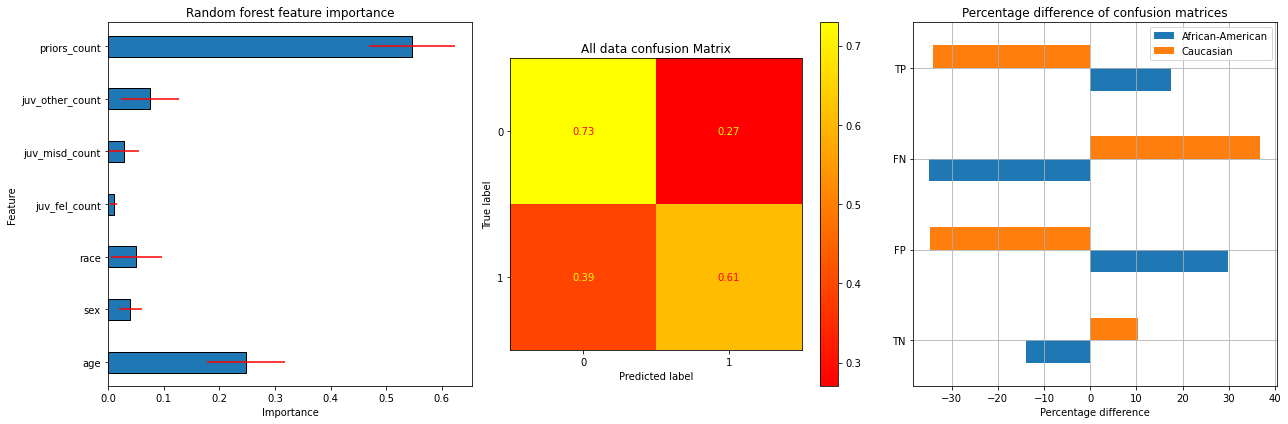

In [139]:
# Collect plots into final cell
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
forest_importances.plot.barh(xerr=std, ax=axs[0], width=0.4, ecolor='red', edgecolor='black')
axs[0].set(
    title="Random forest feature importance",
    ylabel="Feature",
    xlabel='Importance'
)

# Plot 2
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=clf.predict(X_test), cmap='autumn', normalize='true',
                                        ax=axs[1])
axs[1].set(
    title='All data confusion Matrix'
)

# Plot 3
df_D.T.plot.barh(ax=axs[2])

axs[2].set(
    title='Percentage difference of confusion matrices',
    xlabel='Percentage difference'
)
axs[2].grid(True)

plt.tight_layout()
plt.show()

**Results from the classification task.** Write this section here. The aim is to show that the model is biased as it is learning from biased data. Relate this part to the second visualization.

In [181]:
# Structure first plotting data in a dataframe
df_plot_1 = pd.DataFrame(np.hstack([roc_aa, roc_ca[:, 1:]]), columns=['th', 'FPR_AA', 'TPR_AA', 'FPR_CA', 'TPR_CA'])

def roc_curve_no_th(y_test, y_hat):
    """
    Simple roc curve without threshold. Used to compare debias method.

    :param y_test: True y labels
    :param y_hat: Predicted y labels
    :return:
    """
    roc = np.array([])
    #compute TPR and FPR
    TPR, FPR = get_tpr_fpr(y_hat, y_test)
    roc = np.append(roc, [FPR, TPR])
    #return roc
    return roc.reshape(-1, 2)

# Get the roc curves
roc_ca_after = roc_curve(y_test_ca, clf.predict_proba(X_test_ca), [th_ca])
roc_aa_after = roc_curve(y_test_aa, clf.predict_proba(X_test_aa), [th_aa])

roc_ca_before = roc_curve_no_th(y_test_ca, clf.predict(X_test_ca))
roc_aa_before = roc_curve_no_th(y_test_aa, clf.predict(X_test_aa))

# Structure second plotting data in a dataframe
df_plot_2 = pd.DataFrame(
                data=np.vstack([
                        np.hstack([roc_aa_before, roc_ca_before]),
                        np.hstack([roc_aa_after[:, 1:], roc_ca_after[:, 1:]])
                    ]),
                columns=['FPR_AA', 'TPR_AA', 'FPR_CA', 'TPR_CA'],
                index=['Before', 'After']).T


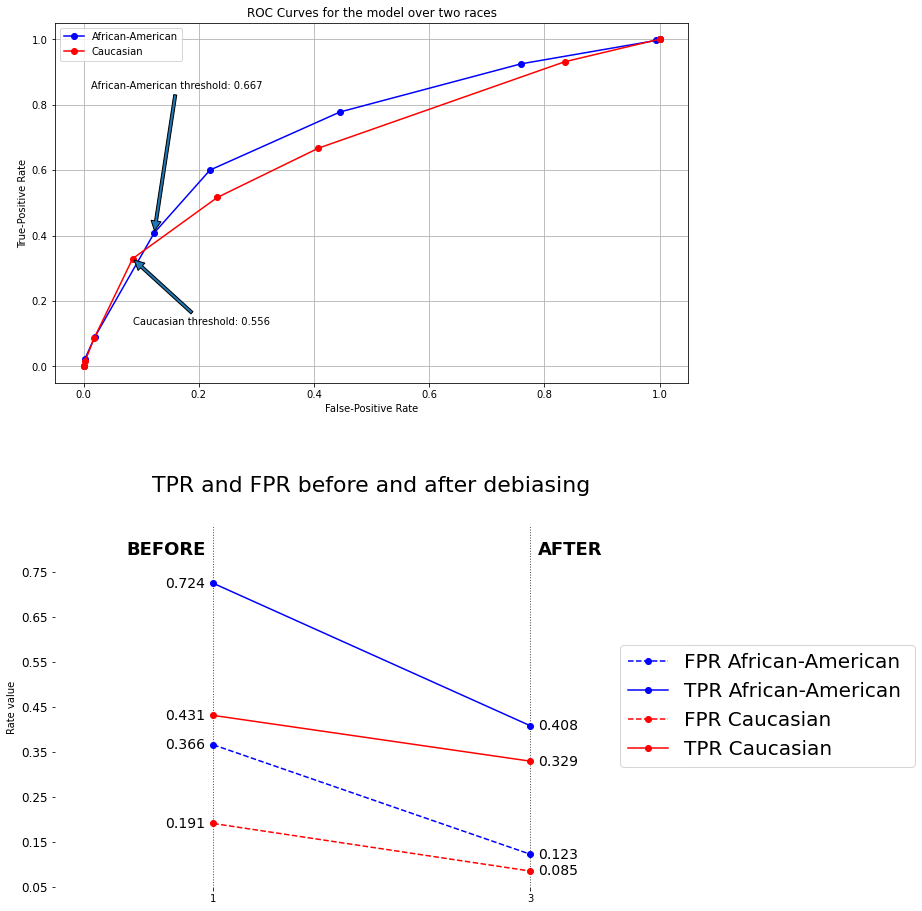

In [226]:
#Third viz here: (Week 8 Visualization 3) plot with 2 subplots (ROC curve and selected threshold, TPR and FPR before and after debiasing)
import matplotlib.lines as mlines

fig, axs = plt.subplots(2, 1, figsize=(11, 15))

##############################################################
# ROC Curve and selected threshold
##############################################################

# Set options that are used for both plots
common_options = {
    'ax': axs[0],
    'style': 'o-'
}

# Plot African-American scatter + line plot
df_plot_1.plot(x='FPR_AA',
             y='TPR_AA',
             color='blue',
             label='African-American',
             **common_options)

# Plot Caucasian scatter + line plot
df_plot_1.plot(x='FPR_CA',
             y='TPR_CA',
             color='red',
             label='Caucasian',
             **common_options)

# Set labels
axs[0].set(
    title='ROC Curves for the model over two races',
    xlabel='False-Positive Rate',
    ylabel='True-Positive Rate'
)

# Create arrow to threshold
row = df_plot_1.iloc[6, :]
row2 = df_plot_1.iloc[5, :]

axs[0].annotate(f'African-American threshold: {row["th"]:.3f}', xy=(row['FPR_AA'], row['TPR_AA']),
             xytext=(row['FPR_AA'] - 0.11, row['TPR_AA'] + 0.44),
             arrowprops=dict(
                 arrowstyle='simple,tail_width=0.3,head_width=1,head_length=1')
             )

axs[0].annotate(f'Caucasian threshold: {row2["th"]:.3f}', xy=(row2['FPR_CA'], row2['TPR_CA']),
             xytext=(row2['FPR_CA'], row2['TPR_CA'] - 0.2),
             arrowprops=dict(
                 arrowstyle='simple,tail_width=0.3,head_width=1,head_length=1')
             )

axs[0].grid(True)

axs[0].legend()

##############################################################
# TPR and FPR before and after debiasing
##############################################################

# draw line
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
def newline(p1, p2, color='black', kwargs={}):
    ax = plt.gca()
    l = mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]], marker='o',
                      markersize=6, **kwargs)
    ax.add_line(l)
    return l

# Vertical Lines
axs[1].vlines(x=1, ymin=0, ymax=1, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
axs[1].vlines(x=3, ymin=0, ymax=1, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
axs[1].scatter(y=df_plot_2['Before'], x=np.repeat(1, df_plot_2.shape[0]), s=10, color='black', alpha=0.7)
axs[1].scatter(y=df_plot_2['After'], x=np.repeat(3, df_plot_2.shape[0]), s=10, color='black', alpha=0.7)

# Color map
color_map = {
    'FPR_AA': 'blue',
    'FPR_CA': 'red',
    'TPR_AA': 'blue',
    'TPR_CA': 'red',
}

line_map = {
    'FPR_AA': '--',
    'FPR_CA': '--',
    'TPR_AA': '-',
    'TPR_CA': '-',
}

column_map = {
    'FPR_AA': 'FPR African-American',
    'FPR_CA': 'FPR Caucasian',
    'TPR_AA': 'TPR African-American ',
    'TPR_CA': 'TPR Caucasian',
}

# Line Segmentsand Annotation
for idx, row in df_plot_2.iterrows():
    p1 = row[0]
    p2 = row[1]

    newline([1, p1], [3, p2], kwargs={
        'color': color_map[idx],
        'label': column_map[idx],
        'linestyle': line_map[idx]
    })
    axs[1].text(1 - 0.05, p1, str(round(p1, 3)), horizontalalignment='right', verticalalignment='center',
            fontdict={'size': 14})
    axs[1].text(3 + 0.05, p2, str(round(p2, 3)), horizontalalignment='left', verticalalignment='center',
            fontdict={'size': 14})

# 'Before' and 'After' Annotations
axs[1].text(1 - 0.05, .8, 'BEFORE', horizontalalignment='right', verticalalignment='center',
        fontdict={'size': 18, 'weight': 700})
axs[1].text(3 + 0.05, .8, 'AFTER', horizontalalignment='left', verticalalignment='center',
        fontdict={'size': 18, 'weight': 700})

# Decoration
axs[1].set_title("TPR and FPR before and after debiasing", fontdict={'size': 22}, pad=35)
axs[1].set(xlim=(0, 4), ylim=(0.05, .85), ylabel='Rate value')
axs[1].set_xticks([1, 3])
# axs[1].set_xticklabels(["1952", "1957"])
plt.yticks(np.arange(0.05, .85, 0.1), fontsize=12)

axs[1].legend(loc=9,
              bbox_to_anchor=(1.125, .7),
              prop={'size': 20})

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
plt.show()

**Results from debiasing method.** Write this section here. The aim is to show that there are methods that can help to enhance fairness in cases as this one. Relate this part to the third visualization.

**Limitations and conclusions.** Write this part here. These are your main take aways, the end of your story, where you should also highlight possible implications/limitations of what you presented.

**References.** Any article need good sources! Whenever you make a statement, refer to data sources, previous studies, methods, etc. add a reference. 

1. reference 1
2. reference 2
3. reference 3
4. etc.

**Assignment Contributions**:

* id1
* id2
* id3